# Unfiltered human PBMCs (10X Genomics)

This is a reimplemintation of the [unfiltered human PBMCs workflow from OSCA Ch. 25](https://osca.bioconductor.org/unfiltered-human-pbmcs-10x-genomics.html). Analysis is done here using both R Bioconductor (implemented with rpy2) and the Python [Scanpy package](https://icb-scanpy.readthedocs-hosted.com/en/stable/api/index.html). Components drawn from the [Theis Lab Scanpy Single Cell Tutorial](https://github.com/theislab/single-cell-tutorial).

From OSCA:

Here, we describe a brief analysis of the peripheral blood mononuclear cell (PBMC) dataset from 10X Genomics (Zheng et al. 2017). The data are publicly available from the 10X Genomics website, from which we download the raw gene/barcode count matrices, i.e., before cell calling from the CellRanger pipeline.

## 0. Load packages

In [1]:
import numpy as np
import pandas as pd
import scanpy as sc
import matplotlib.pyplot as plt
from scipy.sparse import csr_matrix
from scipy.spatial import distance
import seaborn as sns
sns.set()

import rpy2.rinterface_lib.callbacks
import logging
from rpy2.robjects import pandas2ri
import anndata2ri

In [2]:
# Ignore R warning messages
rpy2.rinterface_lib.callbacks.logger.setLevel(logging.ERROR)

# Automatically convert rpy2 outputs to pandas dataframes, and activate anndata2ri 
# for converting to/from AnnData objects
pandas2ri.activate()
anndata2ri.activate()
%load_ext rpy2.ipython

# Set up scanpy settings
sc.settings.verbosity = 3             # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_versions()
sc.settings.set_figure_params(dpi=120)

scanpy==1.4.5.post2 anndata==0.7.1 umap==0.3.10 numpy==1.17.2 scipy==1.3.1 pandas==0.25.1 scikit-learn==0.21.3 statsmodels==0.10.1 python-igraph==0.7.1 louvain==0.6.1


In [3]:
%%R
# Load all the R libraries
library(scran)
library(scater)
library(BiocFileCache)
library(DropletUtils)
library(EnsDb.Hsapiens.v86)

## 1. Data loading, preprocessing, and quality control
All done fully in R.

In [5]:
%%R
bfc <- BiocFileCache("raw_data", ask = FALSE)
raw.path <- bfcrpath(bfc, file.path("http://cf.10xgenomics.com/samples",
    "cell-exp/2.1.0/pbmc4k/pbmc4k_raw_gene_bc_matrices.tar.gz"))
untar(raw.path, exdir=file.path(tempdir(), "pbmc4k"))

fname <- file.path(tempdir(), "pbmc4k/raw_gene_bc_matrices/GRCh38")
sce.pbmc <- read10xCounts(fname, col.names=TRUE)

rownames(sce.pbmc) <- uniquifyFeatureNames(
    rowData(sce.pbmc)$ID, rowData(sce.pbmc)$Symbol)

location <- mapIds(EnsDb.Hsapiens.v86, keys=rowData(sce.pbmc)$ID, 
    column="SEQNAME", keytype="GENEID")

set.seed(100)
e.out <- emptyDrops(counts(sce.pbmc))
sce.pbmc <- sce.pbmc[,which(e.out$FDR <= 0.001)]
unfiltered <- sce.pbmc
stats <- perCellQCMetrics(sce.pbmc, subsets=list(Mito=which(location=="MT")))
high.mito <- isOutlier(stats$subsets_Mito_percent, type="higher")
sce.pbmc <- sce.pbmc[,!high.mito]

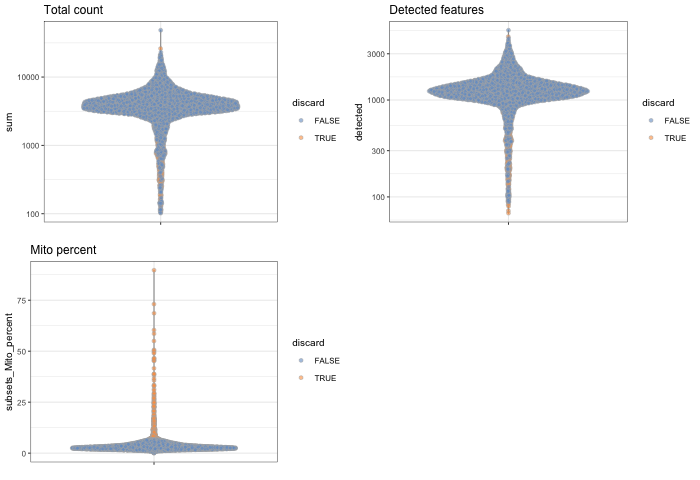

In [6]:
%%R -w 700
colData(unfiltered) <- cbind(colData(unfiltered), stats)
unfiltered$discard <- high.mito

gridExtra::grid.arrange(
    plotColData(unfiltered, y="sum", colour_by="discard") +
        scale_y_log10() + ggtitle("Total count"),
    plotColData(unfiltered, y="detected", colour_by="discard") +
        scale_y_log10() + ggtitle("Detected features"),
    plotColData(unfiltered, y="subsets_Mito_percent",
        colour_by="discard") + ggtitle("Mito percent"),
    ncol=2
)

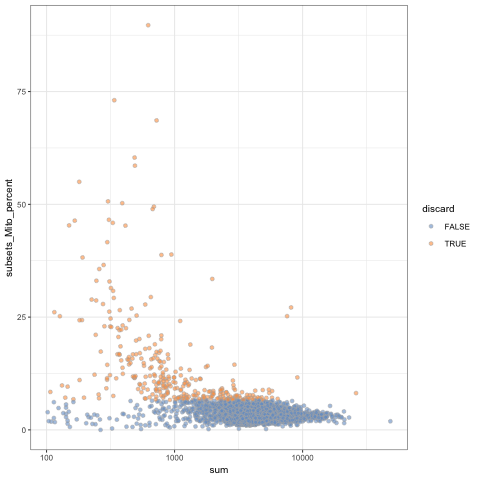

In [7]:
%%R
plotColData(unfiltered, x="sum", y="subsets_Mito_percent",
    colour_by="discard") + scale_x_log10()

## 2. Normalization
At this point, we convert the R SingleCellExperiment to a Python AnnData object. Scanpy only provides normalization by library size, so we use the R scran package for normalization by deconvolution.

In [8]:
%%R -o adata

# Convert to AnnData object
adata <- as(sce.pbmc, 'SingleCellExperiment')

In [9]:
# Calculate quality control metrics
sc.pp.calculate_qc_metrics(adata, inplace=True)

In [10]:
# Perform a clustering for scran normalization in clusters
adata_pp = adata.copy()
sc.pp.normalize_total(adata_pp, key_added='lib_size_factors')
sc.pp.log1p(adata_pp)
sc.pp.pca(adata_pp, n_comps=15)
sc.pp.neighbors(adata_pp)
sc.tl.leiden(adata_pp, key_added='groups', resolution=0.5)

normalizing counts per cell
    finished (0:00:00)
computing PCA with n_comps = 15
    finished (0:00:04)
computing neighbors
    using 'X_pca' with n_pcs = 15
    finished: added to `.uns['neighbors']`
    'distances', distances for each pair of neighbors
    'connectivities', weighted adjacency matrix (0:00:01)
running Leiden clustering
    finished: found 12 clusters and added
    'groups', the cluster labels (adata.obs, categorical) (0:00:00)


In [11]:
# Preprocess variables for scran normalization
input_groups = adata_pp.obs['groups']
data_mat = adata.X.T

In [12]:
%%R -i data_mat,input_groups -o size_factors

size_factors = computeSumFactors(data_mat, clusters=input_groups, min.mean=0.1)

In [13]:
adata.obs['size_factors'] = size_factors
#sc.pp.normalize_total(adata_pp, key_added='lib_size_factors')
adata.obs['lib_size_factors'] = adata_pp.obs['lib_size_factors']

del adata_pp

# Lognormalize the data
sc.pp.log1p(adata)

adata.obs['size_factors'].describe()

count    3922.000000
mean        1.000000
std         0.583917
min         0.023564
25%         0.711922
50%         0.869575
75%         1.088078
max        11.483083
Name: size_factors, dtype: float64

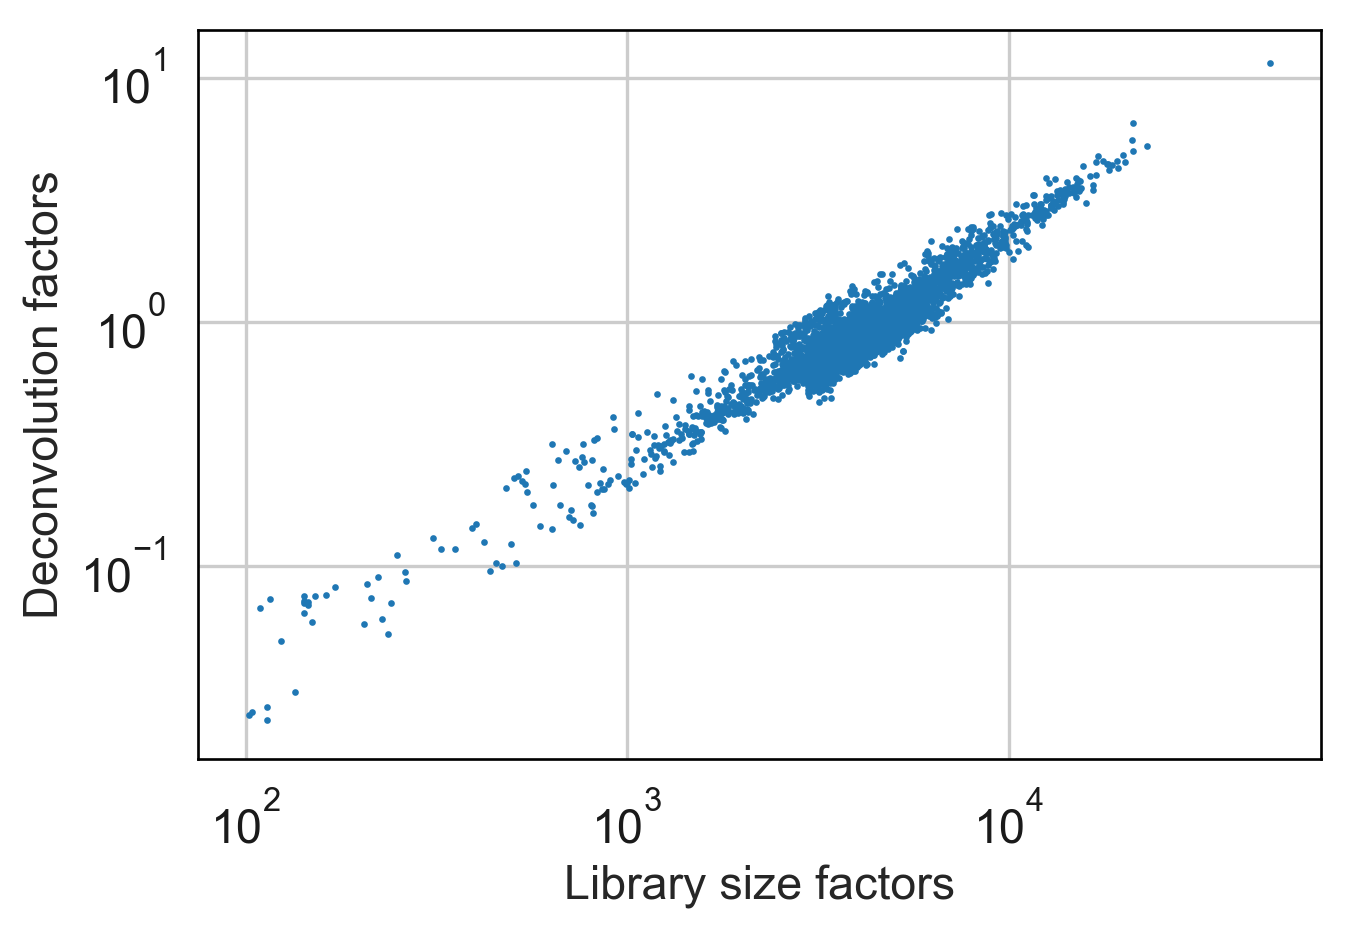

In [18]:
fig, ax = plt.subplots(figsize = (6,4))
ax.scatter(adata.obs['lib_size_factors'],adata.obs['size_factors'],s=1)
ax.set_ylabel('Deconvolution factors')
ax.set_xlabel('Library size factors')
ax.set_xscale('log')
ax.set_yscale('log')

## 3. Variance modeling
Done here in scanpy.

extracting highly variable genes
    finished (0:00:01)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


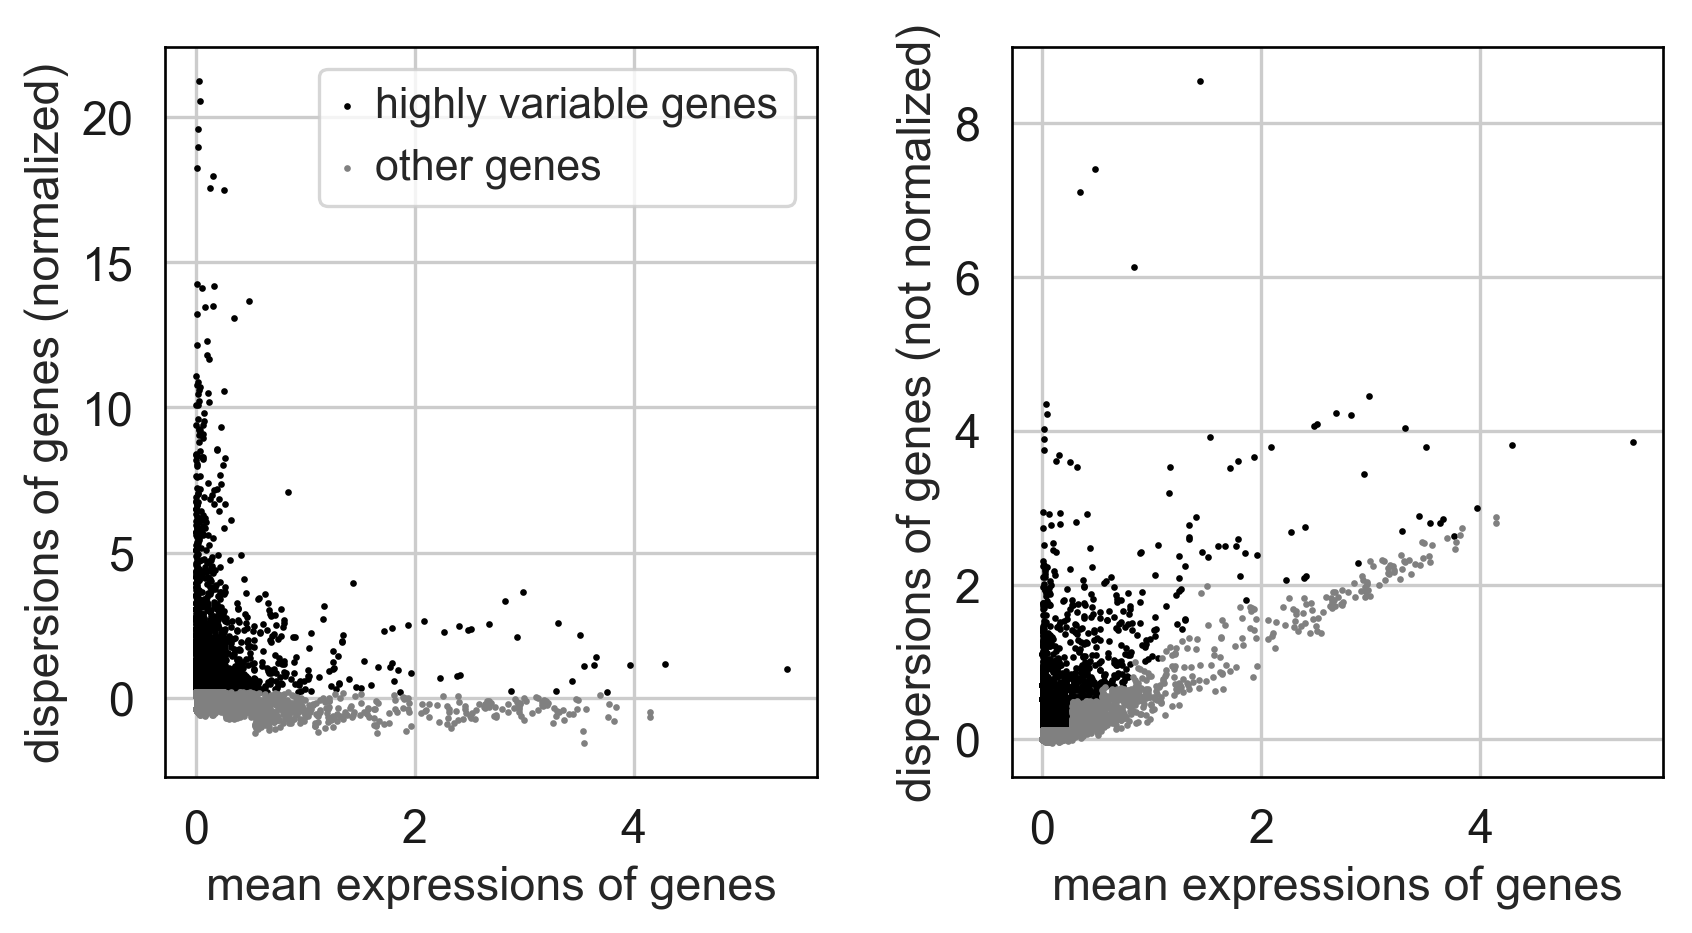

In [20]:
# top 10 percent of genes
n_genes = int(adata.X.shape[1]*0.1)

sc.pp.highly_variable_genes(adata, n_top_genes = n_genes)
sc.pl.highly_variable_genes(adata)

## 4. Dimensionality reduction
Done with scanpy.

In [21]:
sc.pp.pca(adata,use_highly_variable=True)
sc.pp.neighbors(adata)
sc.tl.tsne(adata,random_state = 100000)
sc.tl.umap(adata, random_state = 1000000)

computing PCA with n_comps = 50
    on highly variable genes
    finished (0:00:01)
computing neighbors
    using 'X_pca' with n_pcs = 50
    finished: added to `.uns['neighbors']`
    'distances', distances for each pair of neighbors
    'connectivities', weighted adjacency matrix (0:00:00)
computing tSNE
    using 'X_pca' with n_pcs = 50
    using the 'MulticoreTSNE' package by Ulyanov (2017)
    finished: added
    'X_tsne', tSNE coordinates (adata.obsm) (0:00:24)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:05)


## 5. Clustering
Leiden clustering with scanpy.

In [22]:
sc.tl.leiden(adata)

running Leiden clustering
    finished: found 15 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:00)


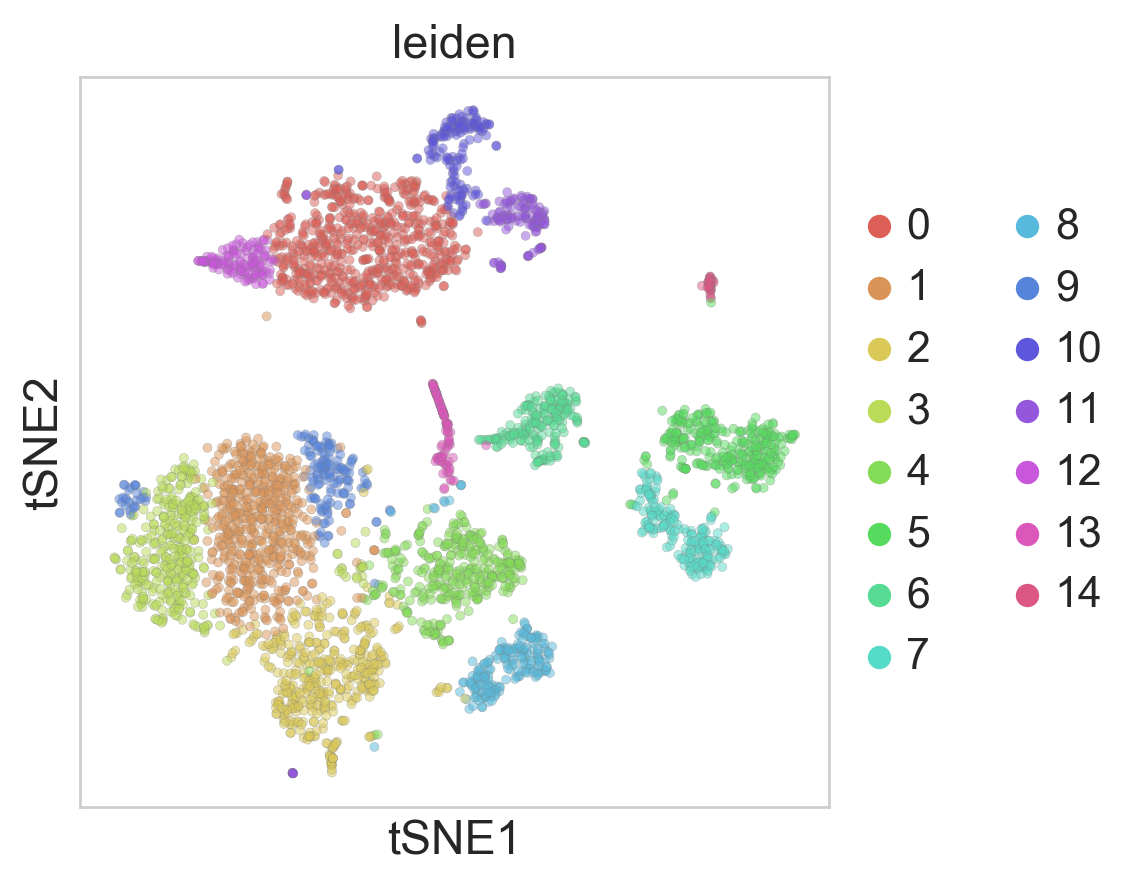

In [25]:
with sns.axes_style('whitegrid'):
    sc.pl.tsne(adata,color='leiden',palette=sns.color_palette("hls", 15),size=30,alpha=0.5,
           edgecolor='gray',linewidth=0.15)

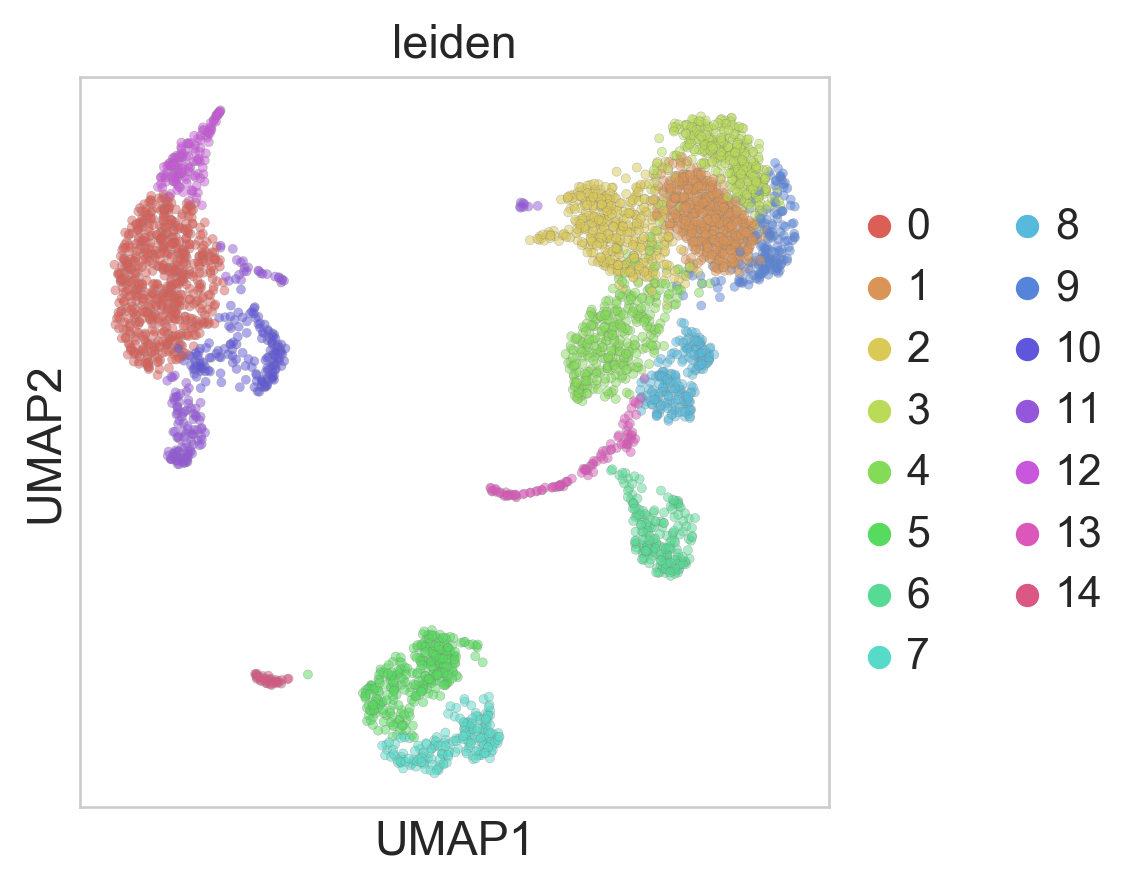

In [26]:
with sns.axes_style('whitegrid'):
    sc.pl.umap(adata, color='leiden',size=30,palette=sns.color_palette("hls", 15),alpha=0.5,
           edgecolor='gray',linewidth=0.15)

## 6. Interpretation

In [27]:
# Calculate marker genes
sc.tl.rank_genes_groups(adata, groupby='leiden', n_genes=10)
sc.tl.dendrogram(adata,groupby='leiden')

ranking genes
    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:01)
    using 'X_pca' with n_pcs = 50
Storing dendrogram info using `.uns['dendrogram_leiden']`


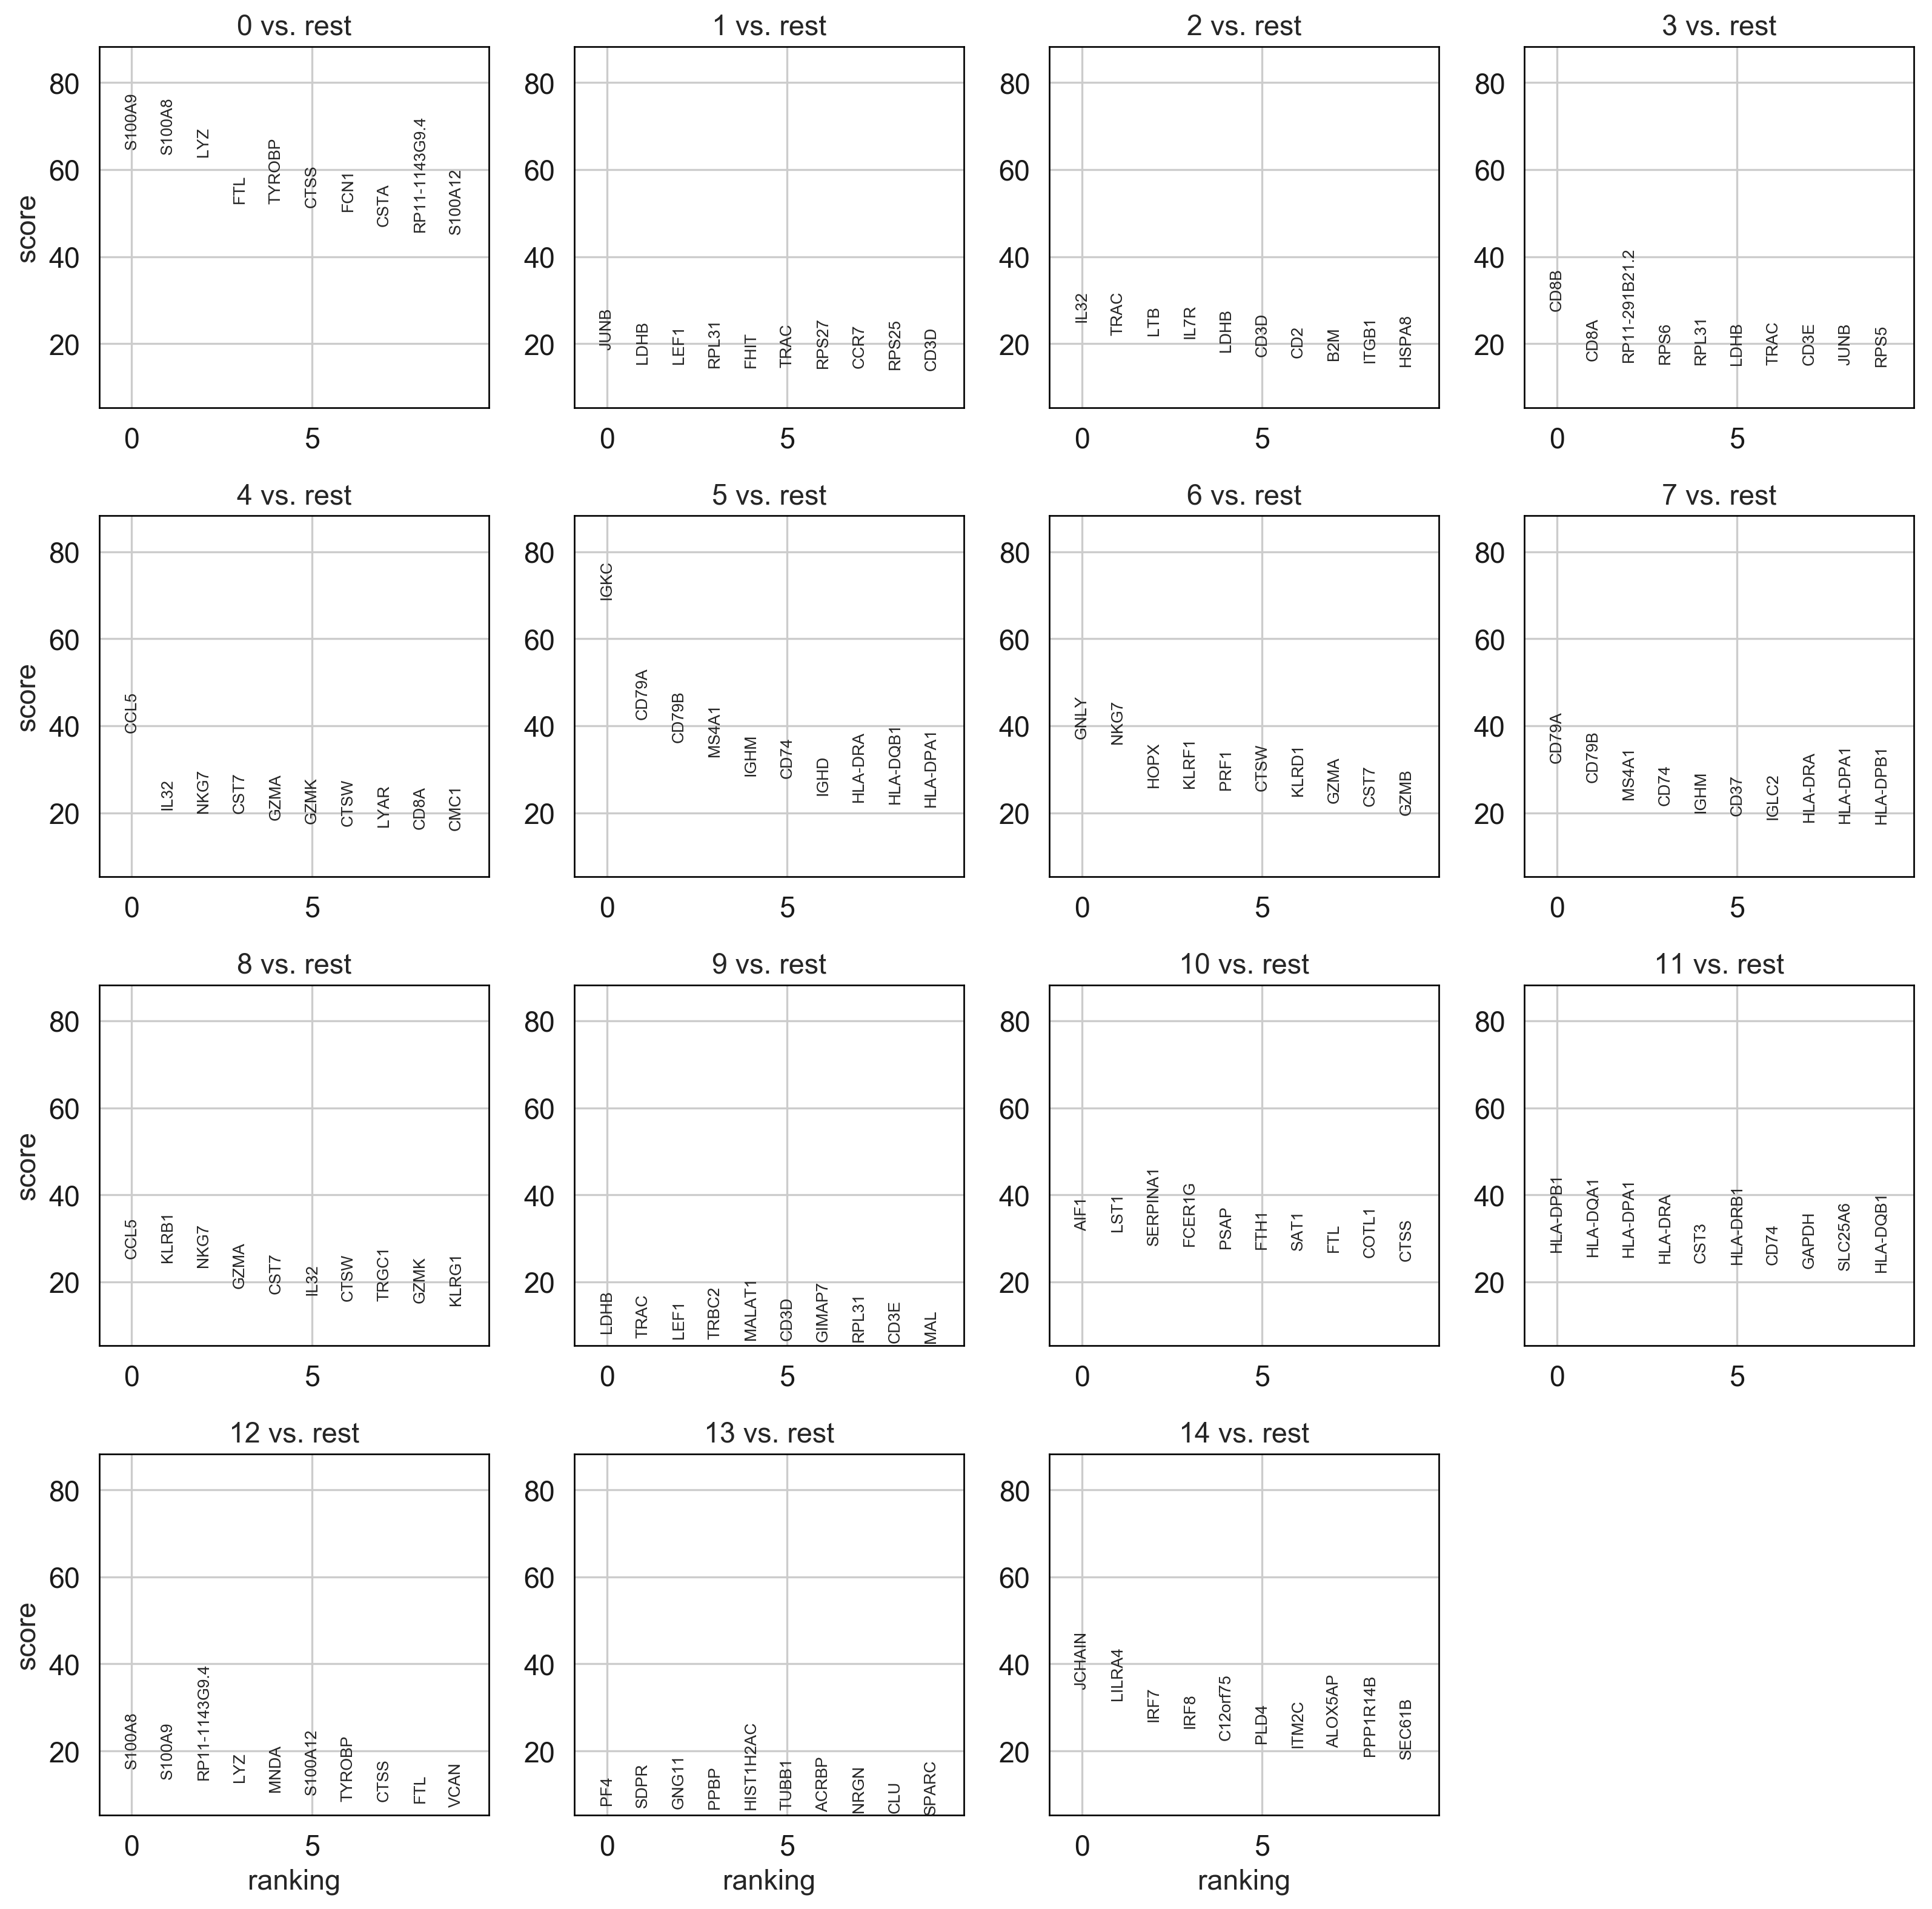

In [28]:
sc.pl.rank_genes_groups(adata)

In [29]:
markers = np.array(['CD14','CD68','MNDA','FCGR3A'])
expression = np.in1d(adata.var_names, markers)

adata.obs['expression'] = adata.X[:,expression].mean(1)

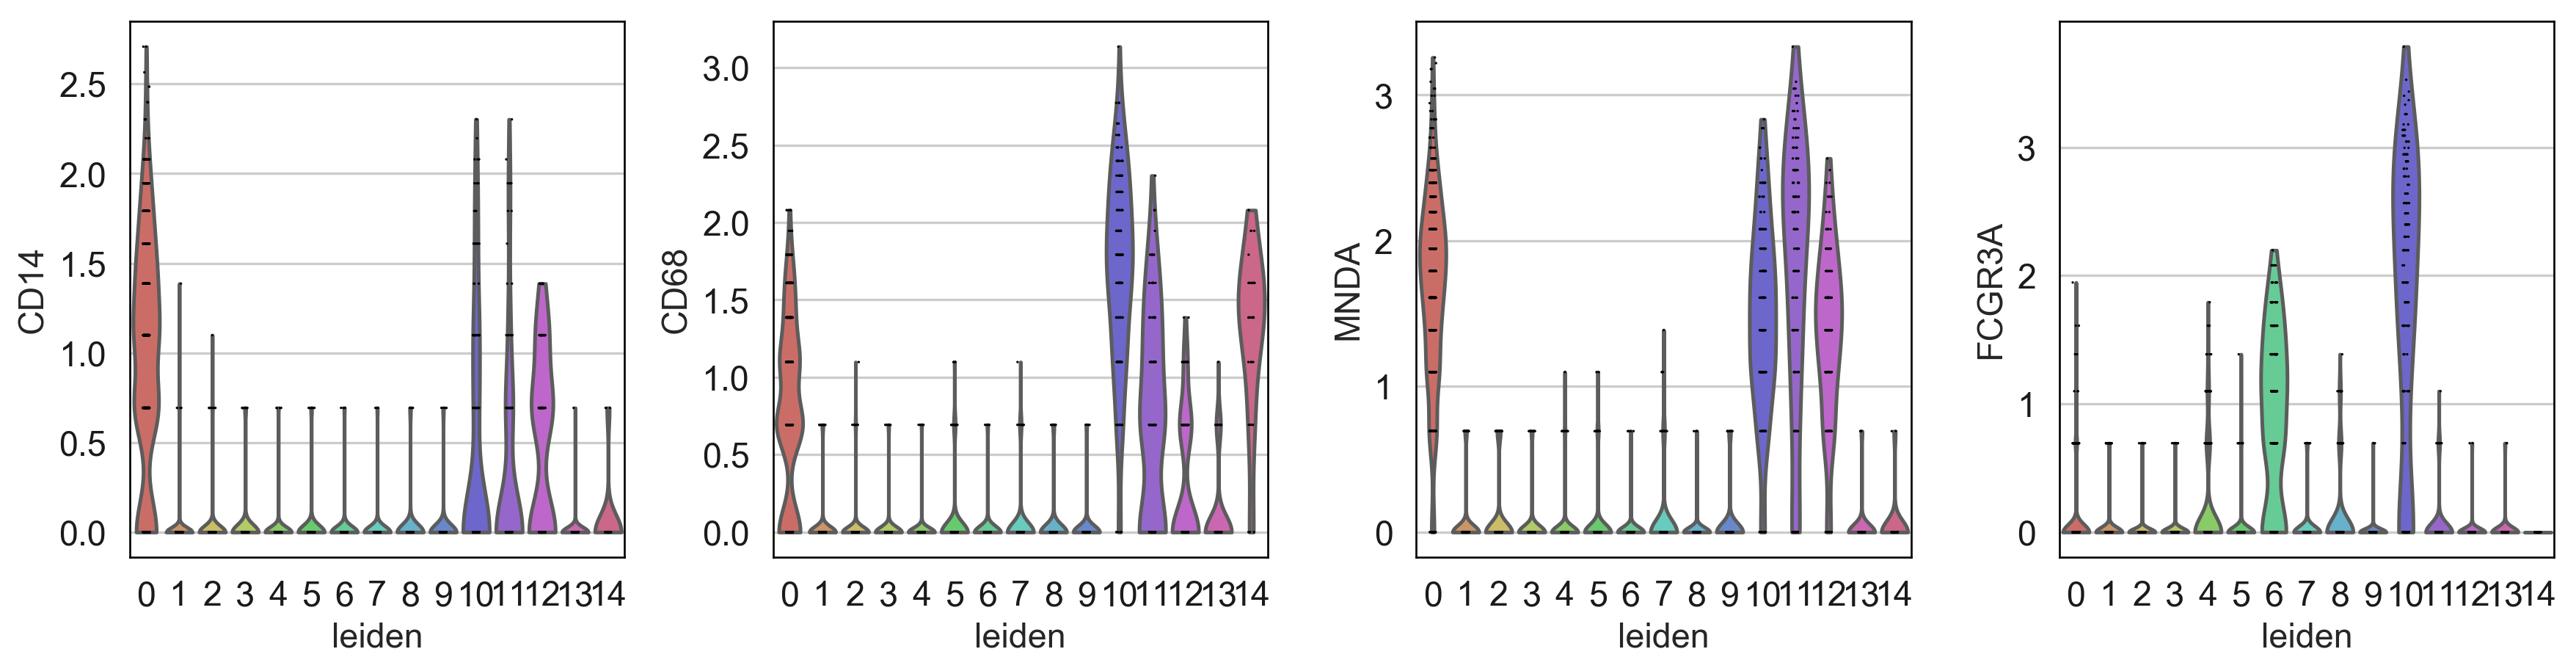

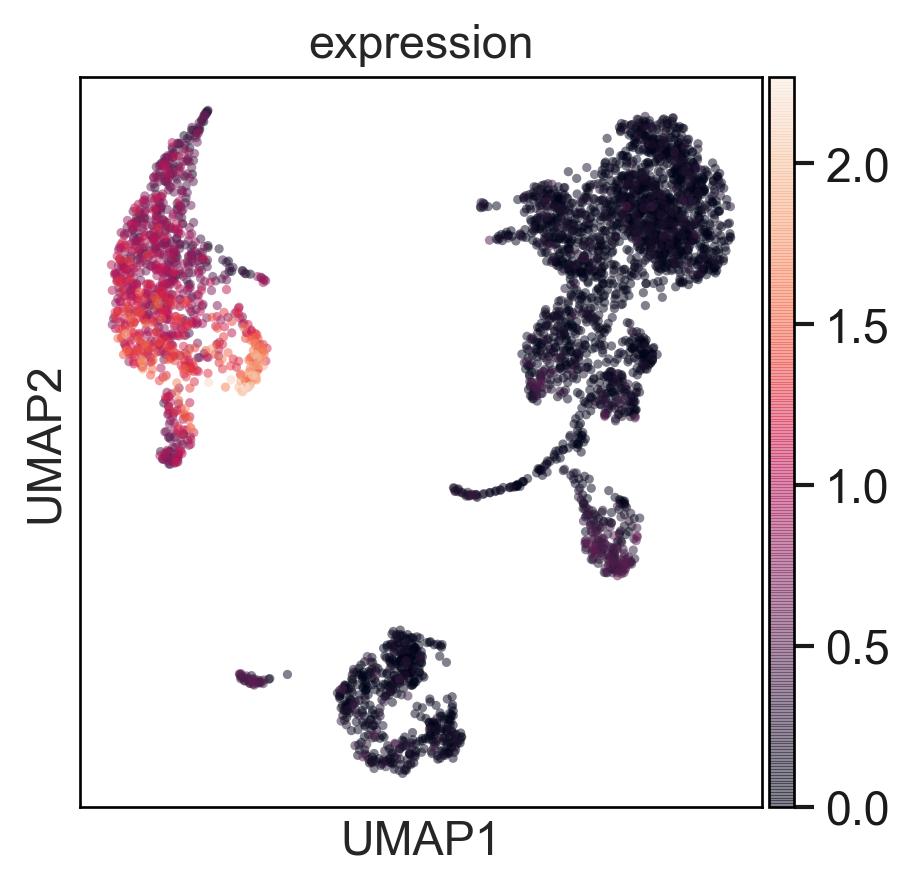

In [30]:
sc.pl.violin(adata, ['CD14','CD68','MNDA','FCGR3A'], groupby='leiden', palette=sns.color_palette("hls", 15),alpha=0.7)
sc.pl.umap(adata, color='expression',alpha=0.5)

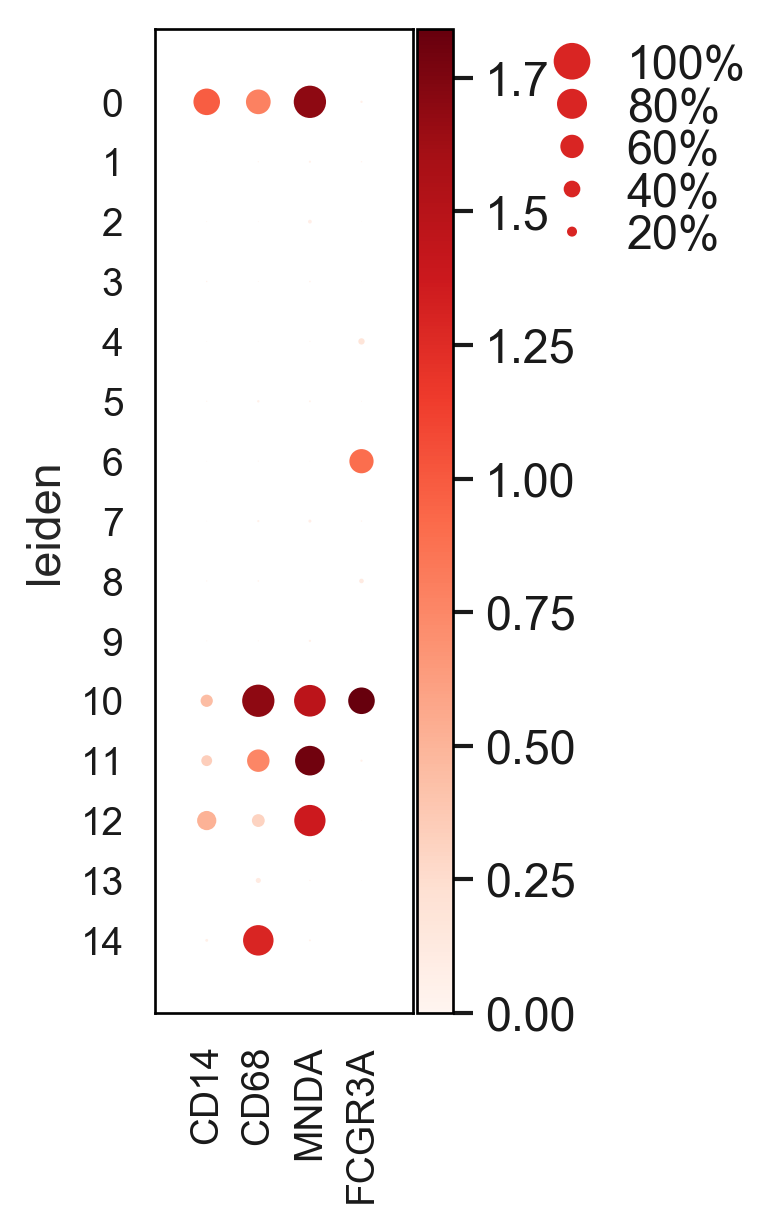

In [31]:
ax = sc.pl.dotplot(adata, markers, groupby='leiden')

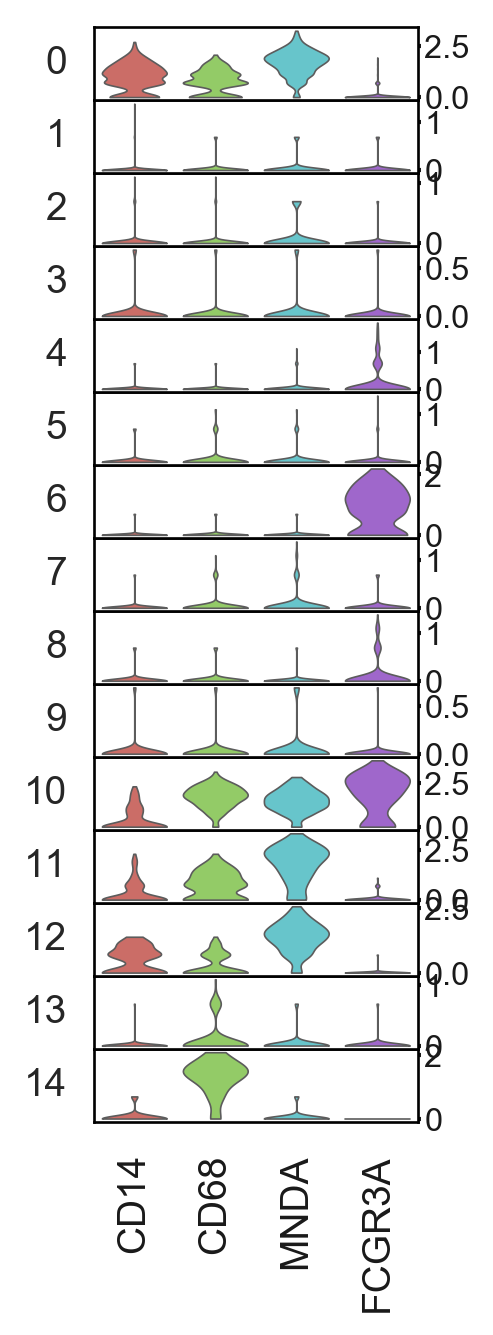

In [32]:
ax = sc.pl.stacked_violin(adata, markers, groupby='leiden', rotation=90,palette=sns.color_palette("hls", 4))